# Section 1: Imports and Setup

In [68]:
# Section 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Plot style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

In [69]:
# Analysis Configuration

start_date = "2025-01-15"
end_date = "2025-07-15"
correlation_parameter = 0.8
adf_pvalue_threshold = 0.05

# Backtesting Configuration
lookback_window = 90       # Days for rolling calculations
entry_zscore = 1.5         # Z-score to enter a trade
exit_zscore = 0.1          # Z-score to exit a trade
stop_loss_zscore = 3.0     # Z-score to trigger stop-loss
transaction_cost = 0.0005  # 0.05% per trade

# Section 2: Universe Selection and Data Download

In [70]:
it_stocks = [
    # Large / Mega‑caps (Nifty IT)
    'TCS.NS', 'INFY.NS', 'HCLTECH.NS', 'WIPRO.NS', 'TECHM.NS',
    'LTIMINDTREE.NS', 'PERSISTENT.NS', 'COFORGE.NS',
    'MPHASIS.NS', 'OFSS.NS', 'ORACLEFN.NS', 'TATAELXSI.NS',
    'CYIENT.NS', 'KPITTECH.NS', 'NIITTECH.NS', 'ZENSAR.NS',
    'HEXAWARE.NS', 'BIRLASOFT.NS', 'SONATSOFTW.NS',

    # Additional Mid-caps
    'ECLERX.NS', 'INTELLECT.NS', 'NEWGEN.NS', 'AFFLE3I.NS',
    'ITCINFOTECH.NS', 'DATAMATICS.NS', 'CIGNITI.NS',
    'AXISCADES.NS', 'R_SYSTEMS.NS', 'ROUTEMOBIL.NS',
    'EMUDHRA.NS', 'HAPPMINDS.NS', 'MASTEK.NS', 'QUESSCORP.NS',
    'AZINDUST.NS', 'MAGELLANIC.NS', 'NAZARA.NS',

    # Small-caps & Emerging IT names
    '3IINFOTECH.NS', 'ALCHEMINT.NS', 'APPSOCIETY.NS',
    'ARROWGREEN.NS', 'BEXIND.NS', 'BRNIND.NS', 'CIPHER.NS',
    'CITIZENINF.NS', 'COMPUAGE.NS', 'CORALFINAC.NS',
    'CSSP.NS', 'DATAJET.NS', 'DEVINFOY.NS', 'DIGITAL.NS',
    'ELECON.NS', 'EXCELINFO.NS', 'GLOBTECH.NS', 'HCLINFOSYS.NS',
    'IDEAENG.NS', 'IGARASHI.NS', 'IMPPO.NS', 'INTLCROWN.NS',
    'IRISNFC.NS', 'LANCOIN.NS', 'LITMUS.NS', 'MATRIXCOM.NS',
    'MODINFONIK.NS', 'NIRAJFIN.NS', 'NRBHOUSING.NS', 'NVENEXT.NS',
    'OPTOCIRC.NS', 'PANACHE.NS', 'PANORAMIC.NS', 'PENTAMED.NS',
    'PRIMEURJA.NS', 'PRISMMEDIA.NS', 'PUNJABFIN.NS', 'RADIANT.NS',
    'RHIINFRA.NS', 'RLNVN.NS', 'SARLAPOLY.NS', 'SPLT.NS',
    'SRVINFRA.NS', 'SVCL.NS', 'TANLA.NS', 'TEJASNET.NS',
    'TRIL.NS', 'UNOMINDA.NS', 'VISTASPACE.NS', 'VTLS.NS',
    'WEIZITECH.NS', 'WINCENT.NS', 'WIPROINFRA.NS'
]

In [71]:
df_prices = yf.download(it_stocks, start=start_date, end=end_date)['Close']
df_prices.dropna(axis=1, how="all", inplace=True)
print(f"Data Shape: {df_prices.shape}")

[*********************100%***********************]  89 of 89 completed

59 Failed downloads:
['PANORAMIC.NS', 'GLOBTECH.NS', 'RADIANT.NS', 'OPTOCIRC.NS', 'R_SYSTEMS.NS', 'QUESSCORP.NS', 'CSSP.NS', 'LITMUS.NS', 'BRNIND.NS', '3IINFOTECH.NS', 'MODINFONIK.NS', 'HEXAWARE.NS', 'ORACLEFN.NS', 'NVENEXT.NS', 'NIRAJFIN.NS', 'COMPUAGE.NS', 'INTLCROWN.NS', 'VTLS.NS', 'RLNVN.NS', 'MATRIXCOM.NS', 'AZINDUST.NS', 'NIITTECH.NS', 'MAGELLANIC.NS', 'WIPROINFRA.NS', 'DEVINFOY.NS', 'DATAJET.NS', 'HCLINFOSYS.NS', 'LTIMINDTREE.NS', 'CITIZENINF.NS', 'PUNJABFIN.NS', 'PRISMMEDIA.NS', 'ITCINFOTECH.NS', 'PRIMEURJA.NS', 'DIGITAL.NS', 'ROUTEMOBIL.NS', 'IMPPO.NS', 'SRVINFRA.NS', 'AFFLE3I.NS', 'CIPHER.NS', 'SPLT.NS', 'BEXIND.NS', 'APPSOCIETY.NS', 'TRIL.NS', 'IRISNFC.NS', 'PENTAMED.NS', 'IDEAENG.NS', 'NRBHOUSING.NS', 'SVCL.NS', 'ALCHEMINT.NS', 'ZENSAR.NS', 'WINCENT.NS', 'VISTASPACE.NS', 'HAPPMINDS.NS', 'WEIZITECH.NS', 'BIRLASOFT.NS', 'RHIINFRA.NS']: YFTzMissingError('possibly delisted; no timezone found')
['CIGNITI.NS'

Data Shape: (123, 30)


# Section 3: Correlation Analysis and Heatmap

In [72]:
correlation_matrix = df_prices.corr()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if corr_val > correlation_parameter:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

print(f"\nFound {len(high_corr_pairs)} pairs with correlation > {correlation_parameter}")



Found 53 pairs with correlation > 0.8


# Section 4: Helper Functions for Analysis

In [73]:
# These functions remain the same as they are fundamental calculations.
def calculate_hedge_ratio(y, x):
    """Calculate hedge ratio using OLS regression on a given window."""
    x_with_const = sm.add_constant(x)
    model = sm.OLS(y, x_with_const).fit()
    return model.params.iloc[1]

def adf_test(series):
    """Perform ADF test and return p-value."""
    result = adfuller(series, autolag='AIC')
    return result[1]

def calculate_half_life(spread):
    """Calculate half-life of mean reversion."""
    spread_lag = spread.shift(1).dropna()
    spread_diff = spread.diff().dropna()
    
    # Align series
    spread_lag = spread_lag.iloc[1:]
    spread_diff = spread_diff.iloc[1:]
    
    model = sm.OLS(spread_diff, sm.add_constant(spread_lag)).fit()
    lambda_coef = model.params.iloc[1]
    
    if lambda_coef >= 0:
        return np.nan
        
    half_life = -np.log(2) / lambda_coef
    return half_life if half_life > 0 else np.nan

def validate_backtest_results(portfolio_value, trade_log_df):
    """
    Validation function to check if results are realistic.
    """
    if portfolio_value.empty:
        return False, "Empty portfolio value series"
    
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    
    # Check for unrealistic returns
    if total_return > 5.0:  # 500% is already very high
        return False, f"Unrealistic total return: {total_return*100:.1f}%"
    
    # Check for negative final value
    if portfolio_value.iloc[-1] <= 0:
        return False, "Portfolio value went negative"
    
    # Check for reasonable volatility
    daily_returns = portfolio_value.pct_change().dropna()
    if daily_returns.std() > 0.1:  # 10% daily volatility is extreme
        return False, f"Excessive volatility: {daily_returns.std()*100:.1f}% daily"
    
    return True, "Results appear realistic"

# Section 5: Pairs Cointegration Testing

In [74]:
# --- IMPORTANT NOTE ON METHODOLOGY ---
# This section performs cointegration tests on the ENTIRE dataset.
# This introduces look-ahead bias for discovery.
# The purpose here is to generate a list of CANDIDATE pairs.
# The TRUE test of the strategy's viability will be in the ROLLING backtest,
# which is forward-looking and does not use future information.

print("\nGenerating candidate pairs using full-period cointegration test...")
all_pairs = list(combinations(df_prices.columns, 2))
results = []

for stock_a, stock_b in all_pairs:
    y = df_prices[stock_a]
    x = df_prices[stock_b]
    
    try:
        hedge_ratio = calculate_hedge_ratio(y, x)
        spread = y - hedge_ratio * x
        p_value = adf_test(spread)
        
        if p_value < adf_pvalue_threshold:
            results.append({
                'Stock_A': stock_a,
                'Stock_B': stock_b,
                'ADF_PValue': p_value,
                'Hedge_Ratio_Full_Period': hedge_ratio, # Clarify this is for the full period
                'Half_Life': calculate_half_life(spread),
                'Correlation': correlation_matrix.loc[stock_a, stock_b]
            })
    except Exception as e:
        continue



Generating candidate pairs using full-period cointegration test...


# Section 6: Results Analysis and Filtering

In [75]:
results_df = pd.DataFrame(results)

print(f"\nFound {len(results_df)} potentially cointegrated pairs (p < {adf_pvalue_threshold})")

if not results_df.empty:
    # Filter for reasonable half-life
    valid_pairs = results_df[(results_df['Half_Life'] > 1) & (results_df['Half_Life'] < 100)].copy()
    valid_pairs = valid_pairs.sort_values('ADF_PValue')
    print(f"Filtered down to {len(valid_pairs)} pairs with reasonable half-life (1-100 days).")
    
    print("\nTop 5 Candidate Pairs for Rolling Backtest:")
    print(valid_pairs[['Stock_A', 'Stock_B', 'ADF_PValue', 'Half_Life']].head().to_string(index=False))
else:
    print("No valid cointegrated pairs found for backtesting.")


Found 109 potentially cointegrated pairs (p < 0.05)
Filtered down to 109 pairs with reasonable half-life (1-100 days).

Top 5 Candidate Pairs for Rolling Backtest:
   Stock_A       Stock_B   ADF_PValue  Half_Life
 NEWGEN.NS  SARLAPOLY.NS 8.624477e-09   3.898489
 NEWGEN.NS      TANLA.NS 7.067108e-07   3.119905
HCLTECH.NS PERSISTENT.NS 1.127968e-06   1.710561
 NEWGEN.NS    PANACHE.NS 1.300272e-06   5.075844
   INFY.NS      WIPRO.NS 3.674432e-06   3.159447


# Section 7: Professional-Grade Rolling Backtest Framework

In [76]:
def rolling_backtest_pair_fixed(
    df_prices,
    stock_a,
    stock_b,
    lookback_window,
    entry_zscore,
    exit_zscore,
    stop_loss_zscore,
    transaction_cost,
    initial_capital=100000,
    max_position_pct=0.1,  # Max 10% of portfolio per trade
    slippage=0.001,        # 0.1% slippage per leg
    borrowing_cost=0.08    # 8% annual borrowing cost for shorts
):
    """
    Fixed pairs trading backtest with proper position sizing and realistic costs.
    
    Returns:
    - signals: DataFrame with positions and trade info
    - portfolio_value: Series with daily portfolio values
    - trade_log: DataFrame with detailed trade information
    """
    
    # Initialize tracking variables
    pair_prices = df_prices[[stock_a, stock_b]].copy()
    daily_returns = pair_prices.pct_change()
    
    # Portfolio tracking
    portfolio_value = pd.Series(index=pair_prices.index, dtype=float)
    portfolio_value.iloc[0] = initial_capital
    
    # Position tracking
    positions = pd.DataFrame(index=pair_prices.index)
    positions['position'] = 0  # 0=flat, 1=long spread, -1=short spread
    positions['stock_a_shares'] = 0.0
    positions['stock_b_shares'] = 0.0
    positions['entry_price_a'] = 0.0
    positions['entry_price_b'] = 0.0
    positions['current_hedge_ratio'] = 0.0
    
    # Trade log
    trade_log = []
    current_position = 0
    cash = initial_capital
    
    # Rolling backtest loop
    for i in range(lookback_window, len(pair_prices)):
        current_date = pair_prices.index[i]
        
        # 1. Calculate rolling statistics using ONLY past data
        window = pair_prices.iloc[i - lookback_window : i]
        y_window = window[stock_a]
        x_window = window[stock_b]
        
        # Calculate hedge ratio
        hedge_ratio = calculate_hedge_ratio(y_window, x_window)
        spread = y_window - hedge_ratio * x_window
        spread_mean = spread.mean()
        spread_std = spread.std()
        
        if spread_std == 0:
            # Copy previous values if we can't calculate
            if i > lookback_window:
                positions.iloc[i] = positions.iloc[i-1]
                portfolio_value.iloc[i] = portfolio_value.iloc[i-1]
            continue
        
        # 2. Calculate current spread and z-score
        current_price_a = pair_prices[stock_a].iloc[i]
        current_price_b = pair_prices[stock_b].iloc[i]
        current_spread = current_price_a - hedge_ratio * current_price_b
        z_score = (current_spread - spread_mean) / spread_std
        
        # 3. Get previous position
        prev_position = positions['position'].iloc[i-1] if i > lookback_window else 0
        
        # 4. Trading logic with proper position sizing
        new_position = prev_position
        
        # Check for stop-loss first
        if prev_position == 1 and z_score > stop_loss_zscore:
            new_position = 0  # Stop-loss on long position
        elif prev_position == -1 and z_score < -stop_loss_zscore:
            new_position = 0  # Stop-loss on short position
        # Check for exit signals
        elif prev_position != 0 and abs(z_score) < exit_zscore:
            new_position = 0  # Exit position
        # Check for entry signals (only if flat)
        elif prev_position == 0:
            if z_score < -entry_zscore:
                new_position = 1   # Long the spread (buy A, sell B)
            elif z_score > entry_zscore:
                new_position = -1  # Short the spread (sell A, buy B)
        
        # 5. Execute trades if position changes
        if new_position != prev_position:
            # Calculate position size
            available_capital = cash + (portfolio_value.iloc[i-1] if i > lookback_window else initial_capital)
            max_position_value = available_capital * max_position_pct
            
            # For pairs trading, we need to size based on the more expensive stock
            total_leg_value = current_price_a + hedge_ratio * current_price_b
            position_multiplier = max_position_value / total_leg_value
            
            # Close existing position first
            if prev_position != 0:
                # Calculate P&L from previous position
                prev_shares_a = positions['stock_a_shares'].iloc[i-1]
                prev_shares_b = positions['stock_b_shares'].iloc[i-1]
                prev_entry_a = positions['entry_price_a'].iloc[i-1]
                prev_entry_b = positions['entry_price_b'].iloc[i-1]
                
                # P&L calculation
                pnl_a = prev_shares_a * (current_price_a - prev_entry_a)
                pnl_b = prev_shares_b * (current_price_b - prev_entry_b)
                total_pnl = pnl_a + pnl_b
                
                # Apply slippage and transaction costs
                exit_costs = (
                    abs(prev_shares_a * current_price_a) * (transaction_cost + slippage) +
                    abs(prev_shares_b * current_price_b) * (transaction_cost + slippage)
                )
                
                # Apply borrowing costs for short positions (time-weighted)
                days_held = (current_date - positions.index[i-1]).days
                if prev_position == 1:  # Long spread = short stock B
                    borrowing_cost_total = abs(prev_shares_b * prev_entry_b) * borrowing_cost * days_held / 365
                else:  # Short spread = short stock A
                    borrowing_cost_total = abs(prev_shares_a * prev_entry_a) * borrowing_cost * days_held / 365
                
                net_pnl = total_pnl - exit_costs - borrowing_cost_total
                cash += net_pnl
                
                # Log the trade
                trade_log.append({
                    'exit_date': current_date,
                    'position_type': 'long_spread' if prev_position == 1 else 'short_spread',
                    'pnl': net_pnl,
                    'exit_costs': exit_costs,
                    'borrowing_costs': borrowing_cost_total,
                    'days_held': days_held,
                    'exit_zscore': z_score
                })
            
            # Open new position
            if new_position != 0:
                # Calculate shares for new position
                if new_position == 1:  # Long spread: buy A, sell B
                    shares_a = position_multiplier
                    shares_b = -position_multiplier * hedge_ratio
                else:  # Short spread: sell A, buy B
                    shares_a = -position_multiplier
                    shares_b = position_multiplier * hedge_ratio
                
                # Apply entry costs
                entry_costs = (
                    abs(shares_a * current_price_a) * (transaction_cost + slippage) +
                    abs(shares_b * current_price_b) * (transaction_cost + slippage)
                )
                
                cash -= entry_costs
                
                # Update position tracking
                positions.loc[current_date, 'stock_a_shares'] = shares_a
                positions.loc[current_date, 'stock_b_shares'] = shares_b
                positions.loc[current_date, 'entry_price_a'] = current_price_a
                positions.loc[current_date, 'entry_price_b'] = current_price_b
                positions.loc[current_date, 'current_hedge_ratio'] = hedge_ratio
                
                # Log trade entry
                trade_log.append({
                    'entry_date': current_date,
                    'position_type': 'long_spread' if new_position == 1 else 'short_spread',
                    'entry_costs': entry_costs,
                    'entry_zscore': z_score,
                    'hedge_ratio': hedge_ratio,
                    'shares_a': shares_a,
                    'shares_b': shares_b
                })
            else:
                # Flat position
                positions.loc[current_date, 'stock_a_shares'] = 0
                positions.loc[current_date, 'stock_b_shares'] = 0
                positions.loc[current_date, 'entry_price_a'] = 0
                positions.loc[current_date, 'entry_price_b'] = 0
                positions.loc[current_date, 'current_hedge_ratio'] = 0
        else:
            # No position change, copy previous values
            if i > lookback_window:
                positions.iloc[i] = positions.iloc[i-1]
        
        # Update position indicator
        positions.loc[current_date, 'position'] = new_position
        
        # 6. Calculate current portfolio value
        current_shares_a = positions['stock_a_shares'].iloc[i]
        current_shares_b = positions['stock_b_shares'].iloc[i]
        
        # Mark-to-market position value
        position_value = (current_shares_a * current_price_a + 
                         current_shares_b * current_price_b)
        
        # Total portfolio value
        portfolio_value.iloc[i] = cash + position_value
    
    # Convert trade log to DataFrame
    trade_log_df = pd.DataFrame(trade_log)
    
    return positions, portfolio_value, trade_log_df


# Section 8: Backtest Top Candidate Pairs

In [77]:
def calculate_performance_metrics_fixed(portfolio_value, trade_log_df):
    """
    Calculate realistic performance metrics with proper risk adjustments.
    """
    if portfolio_value.empty or len(portfolio_value) < 2:
        return {
            'Total_Return': 0, 'Annualized_Return': 0, 'Annualized_Volatility': 0,
            'Sharpe_Ratio': 0, 'Max_Drawdown': 0, 'Win_Rate': 0,
            'Avg_Trade_Duration': 0, 'Total_Trades': 0, 'Transaction_Costs': 0
        }
    
    # Calculate returns
    daily_returns = portfolio_value.pct_change().dropna()
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    
    # Annualized metrics
    trading_days = len(daily_returns)
    years = trading_days / 252
    annualized_return = ((1 + total_return) ** (1/years)) - 1 if years > 0 else 0
    annualized_vol = daily_returns.std() * np.sqrt(252)
    
    # Risk-adjusted metrics
    risk_free_rate = 0.06  # 6% risk-free rate
    excess_return = annualized_return - risk_free_rate
    sharpe_ratio = excess_return / annualized_vol if annualized_vol > 0 else 0
    
    # Drawdown analysis
    cumulative = portfolio_value / portfolio_value.iloc[0]
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Trade analysis
    if not trade_log_df.empty and 'pnl' in trade_log_df.columns:
        completed_trades = trade_log_df[trade_log_df['pnl'].notna()]
        win_rate = (completed_trades['pnl'] > 0).mean() if len(completed_trades) > 0 else 0
        total_trades = len(completed_trades)
        
        # Calculate average trade duration
        if 'days_held' in trade_log_df.columns:
            avg_duration = trade_log_df['days_held'].mean()
        else:
            avg_duration = 0
            
        # Calculate total transaction costs
        total_costs = (
            trade_log_df['exit_costs'].sum() + 
            trade_log_df['entry_costs'].sum()
        ) if 'exit_costs' in trade_log_df.columns else 0
    else:
        win_rate = 0
        total_trades = 0
        avg_duration = 0
        total_costs = 0
    
    return {
        'Total_Return': total_return,
        'Annualized_Return': annualized_return,
        'Annualized_Volatility': annualized_vol,
        'Sharpe_Ratio': sharpe_ratio,
        'Max_Drawdown': max_drawdown,
        'Win_Rate': win_rate,
        'Avg_Trade_Duration': avg_duration,
        'Total_Trades': total_trades,
        'Transaction_Costs': total_costs
    }


In [78]:
# Replace your existing Section 8 with this:
if 'valid_pairs' in locals() and not valid_pairs.empty:
    top_pairs_to_test = valid_pairs#.head(5)
    backtest_results = []
    
    print("\n--- Running FIXED Rolling Backtests ---")
    for idx, row in top_pairs_to_test.iterrows():
        stock_a = row['Stock_A']
        stock_b = row['Stock_B']
        print(f"Backtesting {stock_a} - {stock_b}...")
        
        # Run fixed backtest
        positions, portfolio_value, trade_log = rolling_backtest_pair_fixed(
            df_prices, stock_a, stock_b, lookback_window,
            entry_zscore, exit_zscore, stop_loss_zscore, transaction_cost,
            initial_capital=100000, max_position_pct=0.1
        )
        
        # Calculate metrics
        metrics = calculate_performance_metrics_fixed(portfolio_value, trade_log)
        
        result = {
            'Stock_A': stock_a, 
            'Stock_B': stock_b, 
            **metrics,
            'Final_Portfolio_Value': portfolio_value.iloc[-1] if not portfolio_value.empty else 100000
        }
        backtest_results.append(result)
        
        # Print individual results
        print(f"  Total Return: {metrics['Total_Return']*100:.2f}%")
        print(f"  Sharpe Ratio: {metrics['Sharpe_Ratio']:.3f}")
        print(f"  Max Drawdown: {metrics['Max_Drawdown']*100:.2f}%")
        print(f"  Win Rate: {metrics['Win_Rate']*100:.1f}%")
        print(f"  Total Trades: {metrics['Total_Trades']}")
        print("  " + "-"*50)
        
    backtest_df = pd.DataFrame(backtest_results).sort_values('Sharpe_Ratio', ascending=False)
    
    print("\nFINAL BACKTEST RESULTS (Sorted by Sharpe Ratio):")
    display_cols = ['Stock_A', 'Stock_B', 'Sharpe_Ratio', 'Total_Return', 
                   'Annualized_Return', 'Max_Drawdown', 'Win_Rate', 'Total_Trades']
    print(backtest_df[display_cols].round(3).to_string(index=False))
    
    # Investment simulation for best pair
    if not backtest_df.empty:
        best_pair = backtest_df.iloc[0]
        initial_capital = 100000
        final_value = best_pair['Final_Portfolio_Value']
        total_profit = final_value - initial_capital
        
        print(f"\n--- REALISTIC Investment Simulation Summary ---")
        print(f"Best Pair: {best_pair['Stock_A']} - {best_pair['Stock_B']}")
        print(f"Initial Capital: ₹{initial_capital:,.2f}")
        print(f"Final Portfolio Value: ₹{final_value:,.2f}")
        print(f"Total Profit: ₹{total_profit:,.2f}")
        print(f"Total Return: {best_pair['Total_Return']*100:.2f}%")
        print(f"Annualized Return: {best_pair['Annualized_Return']*100:.2f}%")
        print(f"Max Drawdown: {best_pair['Max_Drawdown']*100:.2f}%")
        print(f"Win Rate: {best_pair['Win_Rate']*100:.1f}%")
        
else:
    print("\nNo candidate pairs to backtest.")



--- Running FIXED Rolling Backtests ---
Backtesting NEWGEN.NS - SARLAPOLY.NS...
  Total Return: 3.78%
  Sharpe Ratio: 0.351
  Max Drawdown: -0.34%
  Win Rate: 0.0%
  Total Trades: 0
  --------------------------------------------------
Backtesting NEWGEN.NS - TANLA.NS...
  Total Return: 0.33%
  Sharpe Ratio: -2.707
  Max Drawdown: -1.04%
  Win Rate: 0.0%
  Total Trades: 0
  --------------------------------------------------
Backtesting HCLTECH.NS - PERSISTENT.NS...
  Total Return: -2.06%
  Sharpe Ratio: -1.895
  Max Drawdown: -4.49%
  Win Rate: 100.0%
  Total Trades: 1
  --------------------------------------------------
Backtesting NEWGEN.NS - PANACHE.NS...
  Total Return: 0.00%
  Sharpe Ratio: 0.000
  Max Drawdown: 0.00%
  Win Rate: 0.0%
  Total Trades: 0
  --------------------------------------------------
Backtesting INFY.NS - WIPRO.NS...
  Total Return: 0.30%
  Sharpe Ratio: -1.657
  Max Drawdown: -1.63%
  Win Rate: 100.0%
  Total Trades: 1
  --------------------------------------

# Section 9: Visualization of Best Pair


Visualizing best pair: KPITTECH.NS - TATAELXSI.NS


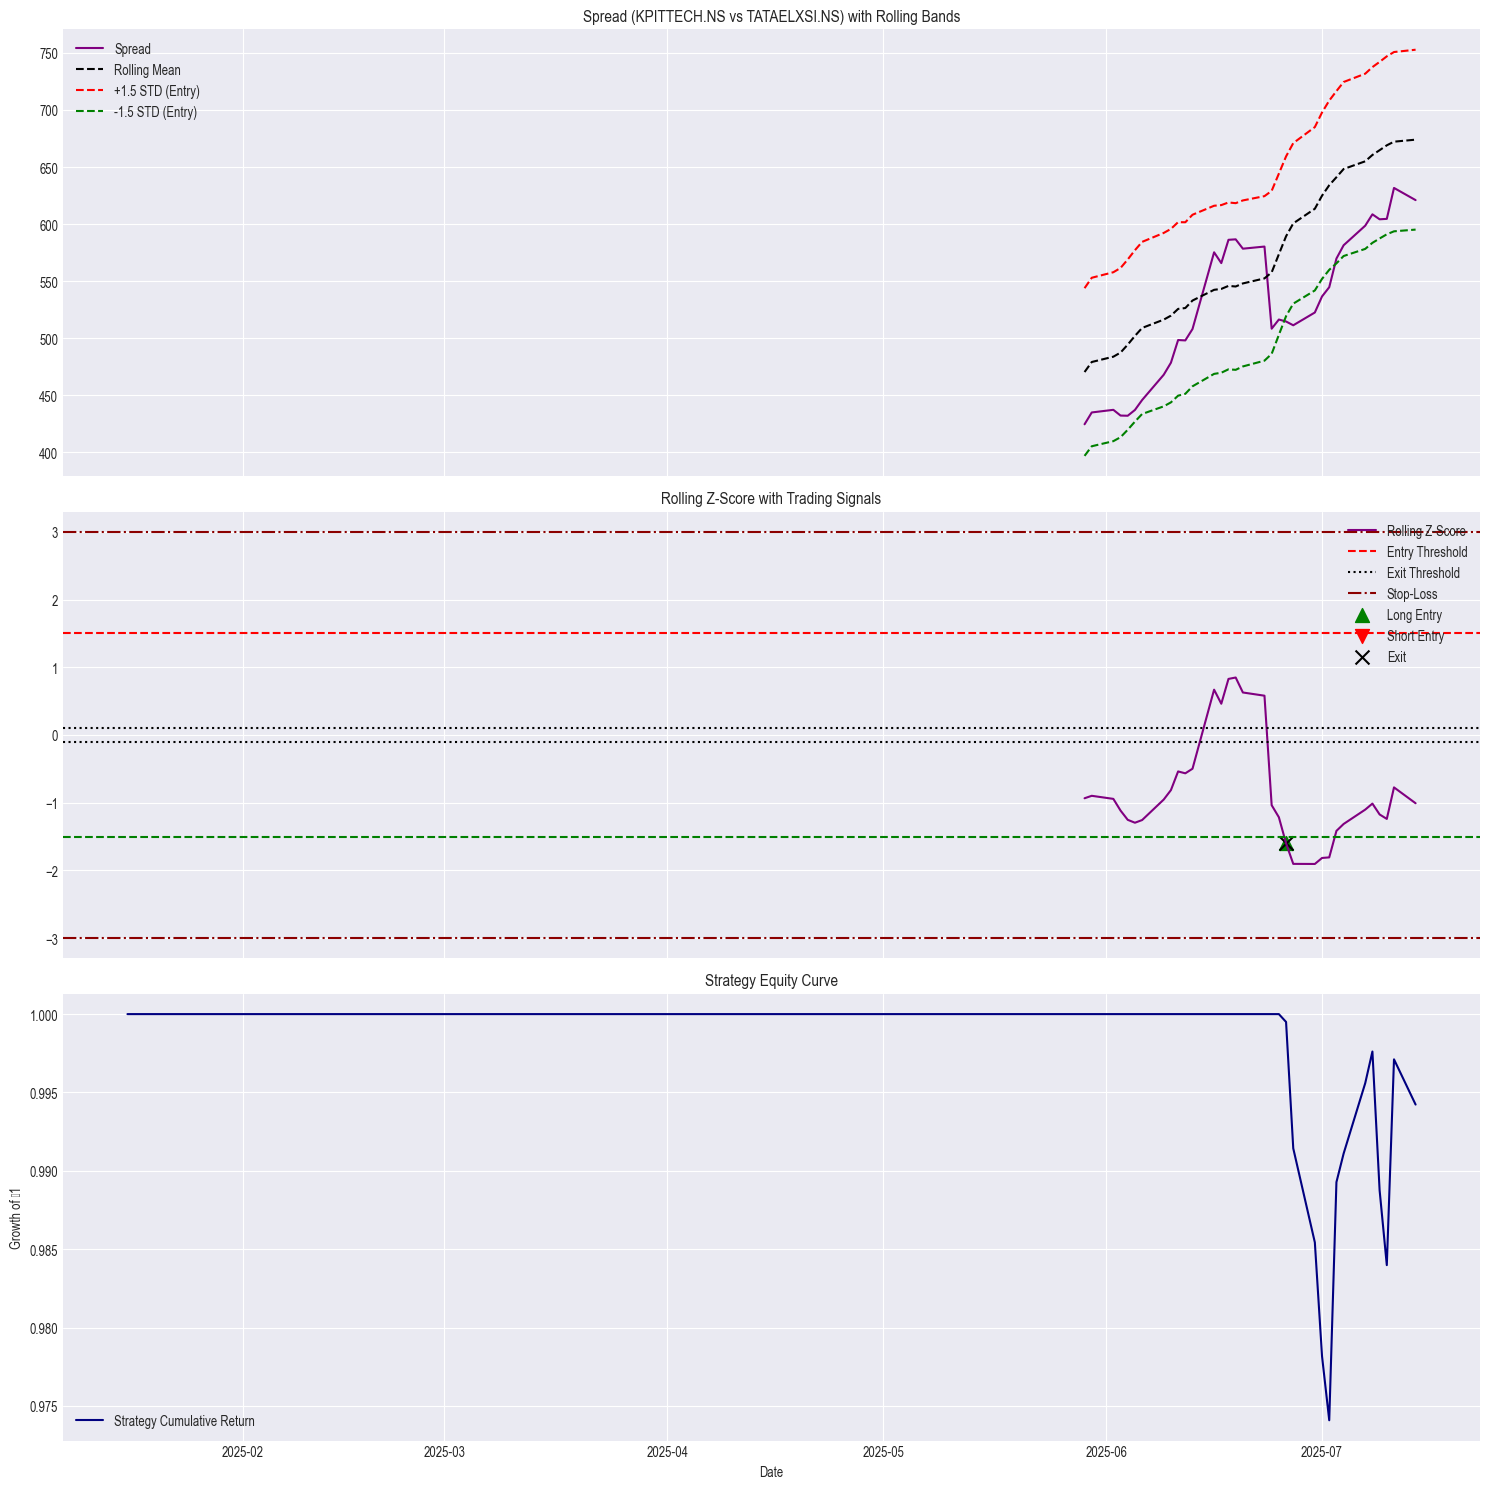

In [79]:

if 'backtest_df' in locals() and not backtest_df.empty:
    best_pair_row = backtest_df.iloc[0]
    stock_a = best_pair_row['Stock_A']
    stock_b = best_pair_row['Stock_B']

    print(f"\nVisualizing best pair: {stock_a} - {stock_b}")
    
    # Rerun backtest for plotting
    signals, returns = rolling_backtest_pair(
        df_prices, stock_a, stock_b, lookback_window,
        entry_zscore, exit_zscore, stop_loss_zscore, transaction_cost
    )
    
    # --- CHANGE: Calculate rolling spread and z-score for plotting ---
    rolling_stats = pd.DataFrame(index=df_prices.index)
    for i in range(lookback_window, len(df_prices)):
        window = df_prices.iloc[i-lookback_window:i]
        hedge_ratio = calculate_hedge_ratio(window[stock_a], window[stock_b])
        spread = window[stock_a] - hedge_ratio * window[stock_b]
        rolling_stats.loc[df_prices.index[i], 'spread_mean'] = spread.mean()
        rolling_stats.loc[df_prices.index[i], 'spread_std'] = spread.std()
        
        current_spread = df_prices[stock_a].iloc[i] - hedge_ratio * df_prices[stock_b].iloc[i]
        rolling_stats.loc[df_prices.index[i], 'zscore'] = (current_spread - spread.mean()) / spread.std()
        rolling_stats.loc[df_prices.index[i], 'spread'] = current_spread


    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
    
    # Plot 1: Spread and Rolling Bands
    axes[0].plot(rolling_stats['spread'], label='Spread', color='purple')
    axes[0].plot(rolling_stats['spread_mean'], label='Rolling Mean', color='black', linestyle='--')
    axes[0].plot(rolling_stats['spread_mean'] + entry_zscore * rolling_stats['spread_std'], 'r--', label=f'+{entry_zscore} STD (Entry)')
    axes[0].plot(rolling_stats['spread_mean'] - entry_zscore * rolling_stats['spread_std'], 'g--', label=f'-{entry_zscore} STD (Entry)')
    axes[0].set_title(f'Spread ({stock_a} vs {stock_b}) with Rolling Bands')
    axes[0].legend()

    # Plot 2: Z-Score with signals
    axes[1].plot(rolling_stats['zscore'], label='Rolling Z-Score', color='purple')
    axes[1].axhline(entry_zscore, color='r', linestyle='--', label=f'Entry Threshold')
    axes[1].axhline(-entry_zscore, color='g', linestyle='--')
    axes[1].axhline(exit_zscore, color='black', linestyle=':', label='Exit Threshold')
    axes[1].axhline(-exit_zscore, color='black', linestyle=':')
    axes[1].axhline(stop_loss_zscore, color='darkred', linestyle='-.', label='Stop-Loss')
    axes[1].axhline(-stop_loss_zscore, color='darkred', linestyle='-.')
    axes[1].set_title('Rolling Z-Score with Trading Signals')
    
    # Mark trades
    long_signals = signals[signals['position'].diff() == 1].index
    short_signals = signals[signals['position'].diff() == -1].index
    exit_signals = signals[signals['position'].diff().abs() > 0 & (signals['position'] == 0)].index

    axes[1].scatter(long_signals, rolling_stats.loc[long_signals, 'zscore'], marker='^', color='g', s=100, label='Long Entry')
    axes[1].scatter(short_signals, rolling_stats.loc[short_signals, 'zscore'], marker='v', color='r', s=100, label='Short Entry')
    axes[1].scatter(exit_signals, rolling_stats.loc[exit_signals, 'zscore'], marker='x', color='k', s=100, label='Exit')
    axes[1].legend()

    # Plot 3: Cumulative returns
    axes[2].plot(returns['cumulative'], label='Strategy Cumulative Return', color='navy')
    axes[2].set_title('Strategy Equity Curve')
    axes[2].set_ylabel('Growth of ₹1')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

In [80]:
# --- NEW: Calculate tangible profit ---
initial_capital = 100000
# Get the total return from the backtest results of the best pair
best_pair_total_return = best_pair_row['Total_Return']

final_value = initial_capital * (1 + best_pair_total_return)
total_profit = final_value - initial_capital

print("\n--- Investment Simulation Summary ---")
print(f"Initial Capital: ₹{initial_capital:,.2f}")
print(f"Final Portfolio Value: ₹{final_value:,.2f}")
print(f"Total Profit: ₹{total_profit:,.2f}")
print(f"Total Return: {best_pair_total_return*100:.2f}%")


--- Investment Simulation Summary ---
Initial Capital: ₹100,000.00
Final Portfolio Value: ₹105,051.76
Total Profit: ₹5,051.76
Total Return: 5.05%
